In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import lightgbm as lgb
import seaborn as sns
import xgboost as xg
import lightgbm as lgb

In [2]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_log_error

In [3]:
train_df  = pd.read_csv("TRAIN.csv")
test_df  = pd.read_csv("TEST_FINAL.csv")

In [4]:
def plot_res(s_id):
    temp_df = train_df.loc[(train_df['Store_id'] == s_id)]
    y_lst = temp_df['Sales'].tolist()
    plt.rcParams["figure.figsize"] = (20,5)
    plt.plot(y_lst, c='royalblue')
    ax = plt.gca()
    ax.set_ylabel('Sales')
    ax.set_xlabel('Dates')
    plt.show()
    plt.clf()

In [5]:
train_df.head()

,ID,Store_id,Store_Type,Location_Type,Region_Code,Date,Holiday,Discount,#Order,Sales
0,T1000001,1,S1,L3,R1,2018-01-01,1,Yes,9,7011.84
1,T1000002,253,S4,L2,R1,2018-01-01,1,Yes,60,51789.12
2,T1000003,252,S3,L2,R1,2018-01-01,1,Yes,42,36868.20
3,T1000004,251,S2,L3,R1,2018-01-01,1,Yes,23,19715.16
4,T1000005,250,S2,L3,R4,2018-01-01,1,Yes,62,45614.52


## Label encoding categorical variables

In [6]:
train_df['Date'] = pd.to_datetime(train_df['Date'])
test_df['Date'] = pd.to_datetime(test_df['Date'])

In [7]:
combine = [train_df, test_df]
store_type_mapping = {"S1": 1, "S2": 2, "S3": 3, "S4": 4}
for dataset in combine:
    dataset['Store_Type'] = dataset['Store_Type'].map(store_type_mapping).astype(int)
location_type_mapping = {"L1": 1, "L2": 2, "L3": 3, "L4": 4, "L5":5}
for dataset in combine:
    dataset['Location_Type'] = dataset['Location_Type'].map(location_type_mapping).astype(int)
region_code_mapping = {"R1": 1, "R2": 2, "R3": 3, "R4": 4}
for dataset in combine:
    dataset['Region_Code'] = dataset['Region_Code'].map(region_code_mapping).astype(int)
discount_mapping = {"No": 0, "Yes": 1}
for dataset in combine:
    dataset['Discount'] = dataset['Discount'].map(discount_mapping).astype(int)

In [8]:
submission_csv = test_df[['ID','Date','Store_id']]
df_sub = pd.DataFrame(columns = ['ID','Date','Store_id','Sales'])

## Creating is_weekend feature for weekends

In [9]:
train_df['day'] = train_df['Date'].dt.day_name()
train_df['is_weekend'] = 0
train_df.loc[train_df['day'] == 'Saturday', 'is_weekend'] = 1
train_df.loc[train_df['day'] == 'Sunday', 'is_weekend'] = 1
#train_df.loc[train_df['day'] == 'Monday', 'is_weekend'] = 2
#train_df.loc[train_df['day'] == 'Tuesday', 'is_weekend'] = 3
#train_df.loc[train_df['day'] == 'Wednesday', 'is_weekend'] = 4
#train_df.loc[train_df['day'] == 'Thursday', 'is_weekend'] = 5
#train_df.loc[train_df['day'] == 'Friday', 'is_weekend'] = 6

In [10]:
test_df['day'] = test_df['Date'].dt.day_name()
test_df['is_weekend'] = 0
test_df.loc[test_df['day'] == 'Saturday', 'is_weekend'] = 1
test_df.loc[test_df['day'] == 'Sunday', 'is_weekend'] = 1
#test_df.loc[train_df['day'] == 'Monday', 'is_weekend'] = 2
#test_df.loc[train_df['day'] == 'Tuesday', 'is_weekend'] = 3
#test_df.loc[train_df['day'] == 'Wednesday', 'is_weekend'] = 4
#test_df.loc[train_df['day'] == 'Thursday', 'is_weekend'] = 5
#test_df.loc[train_df['day'] == 'Friday', 'is_weekend'] = 6

## tabulating sales by each variable to check its affect

In [11]:
train_df[['Sales', 'day']].groupby(['day'], as_index=False).mean()

,day,Sales
0,Friday,39701.020376
1,Monday,42291.175854
2,Saturday,46729.798143
3,Sunday,49044.051947
4,Thursday,40231.985963
5,Tuesday,40802.966220
6,Wednesday,40827.205395


In [12]:
train_df[['Sales', 'Discount']].groupby(['Discount'], as_index=False).mean()

,Discount,Sales
0,0,37403.679678
1,1,49426.497620


In [13]:
train_df[['Sales', 'Location_Type']].groupby(['Location_Type'], as_index=False).mean()

,Location_Type,Sales
0,1,41453.597889
1,2,59231.480373
2,3,33072.257756
3,4,29067.414313
4,5,25187.787261


In [14]:
train_df[['Sales', 'Region_Code']].groupby(['Region_Code'], as_index=False).mean()

,Region_Code,Sales
0,1,46765.488405
1,2,40054.847344
2,3,42144.517063
3,4,39743.434249


In [15]:
train_df_s = train_df[train_df['Store_id'] == 1]

## plotting one of the series

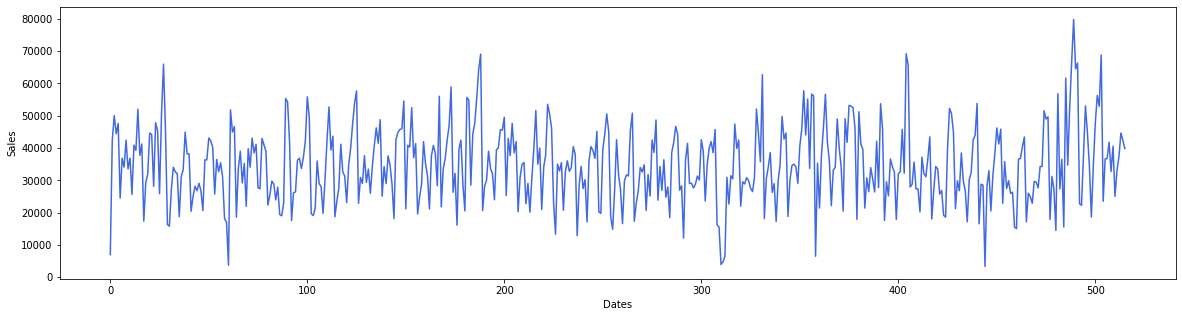

<Figure size 1440x360 with 0 Axes>

In [16]:
plot_res(1)

In [17]:
train_df = train_df.drop(['day'], axis = 1)
test_df = test_df.drop(['day'], axis = 1)

In [18]:
df = train_df.drop(['ID','#Order'], axis = 1)

In [19]:
df.head()

,Store_id,Store_Type,Location_Type,Region_Code,Date,Holiday,Discount,Sales,is_weekend
0,1,1,3,1,2018-01-01,1,1,7011.84,0
1,253,4,2,1,2018-01-01,1,1,51789.12,0
2,252,3,2,1,2018-01-01,1,1,36868.20,0
3,251,2,3,1,2018-01-01,1,1,19715.16,0
4,250,2,3,4,2018-01-01,1,1,45614.52,0


## Creating lags and rolling mean features

In [20]:
lags = [7, 28]
lag_cols = [f"lag_{lag}" for lag in lags ]
for lag, lag_col in zip(lags, lag_cols):
    df[lag_col] = df[["Store_id","Sales"]].groupby("Store_id")["Sales"].shift(lag)

In [21]:
wins = [7, 28]
for win in wins :
    for lag,lag_col in zip(lags, lag_cols):
        df[f"rmean_{lag}_{win}"] = df[["Store_id", lag_col]].groupby("Store_id")[lag_col].transform(lambda x : x.rolling(win).mean()) 

In [22]:
#2019-05-11

In [23]:
df = df.drop(['Store_id'], axis = 1)

In [24]:
df.dropna(inplace = True)

## Creating train and validation sets

In [25]:
df_tr = df.loc[df['Date'] <= pd.Timestamp(2019,5,11)]

In [26]:
df_te = df.loc[df['Date'] > pd.Timestamp(2019,5,11)]

In [27]:
df_tr = df_tr.drop(['Date'], axis = 1)
df_te = df_te.drop(['Date'], axis = 1)

In [28]:
df_tr.head()

,Store_Type,Location_Type,Region_Code,Holiday,Discount,Sales,is_weekend,lag_7,lag_28,rmean_7_7,rmean_28_7,rmean_7_28,rmean_28_28
20075,1,1,2,0,0,35628.0,1,56445.0,44040.0,37095.197143,35487.600000,36751.270714,42790.951071
20076,4,1,1,0,0,39846.0,1,64857.0,70395.0,43182.857143,43084.817143,42283.393929,44797.602857
20077,1,1,2,0,0,41424.0,1,63255.0,75072.0,39562.285714,40214.785714,39476.633571,45375.720000
20078,2,4,4,0,0,26397.0,1,41349.0,33180.0,24763.542857,27344.875714,26007.861429,30073.864286
20079,1,1,1,0,0,27648.0,1,51798.0,57987.0,28757.280000,33255.124286,32289.428571,38939.732143


<AxesSubplot:title={'center':'Pearson Correlation of Features'}>

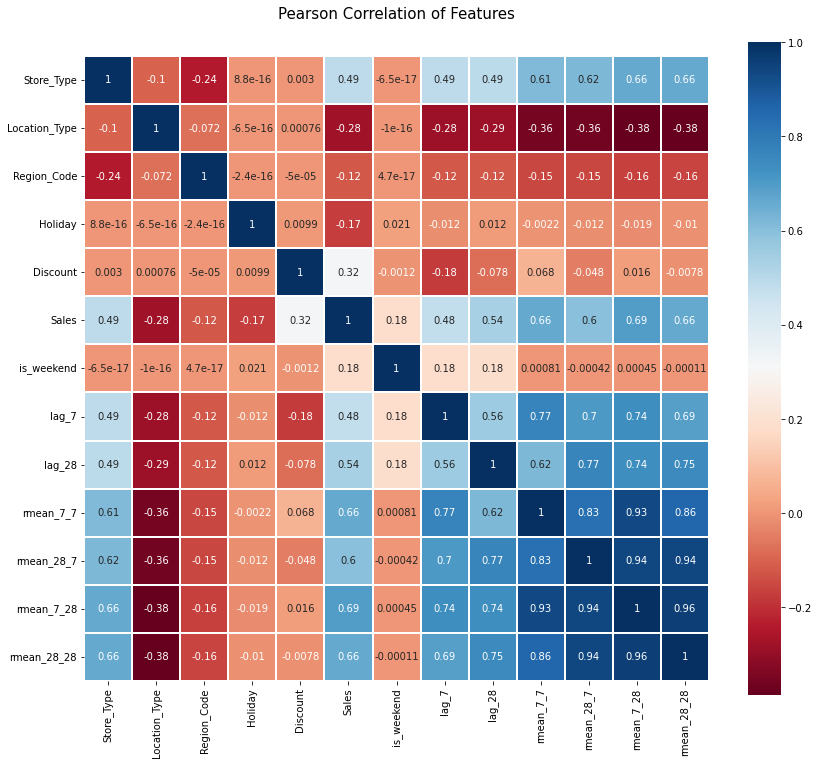

In [29]:
colormap = plt.cm.RdBu
plt.figure(figsize=(14,12))
plt.title('Pearson Correlation of Features', y=1.05, size=15)
sns.heatmap(df_tr.astype(float).corr(),linewidths=0.1,vmax=1.0, 
            square=True, cmap=colormap, linecolor='white', annot=True)

In [30]:
df.head()

,Store_Type,Location_Type,Region_Code,Date,Holiday,Discount,Sales,is_weekend,lag_7,lag_28,rmean_7_7,rmean_28_7,rmean_7_28,rmean_28_28
20075,1,1,2,2018-02-25,0,0,35628.0,1,56445.0,44040.0,37095.197143,35487.600000,36751.270714,42790.951071
20076,4,1,1,2018-02-25,0,0,39846.0,1,64857.0,70395.0,43182.857143,43084.817143,42283.393929,44797.602857
20077,1,1,2,2018-02-25,0,0,41424.0,1,63255.0,75072.0,39562.285714,40214.785714,39476.633571,45375.720000
20078,2,4,4,2018-02-25,0,0,26397.0,1,41349.0,33180.0,24763.542857,27344.875714,26007.861429,30073.864286
20079,1,1,1,2018-02-25,0,0,27648.0,1,51798.0,57987.0,28757.280000,33255.124286,32289.428571,38939.732143


In [31]:
y = df['Sales']

In [32]:
temp_train = df.drop(['Date','Sales'], axis = 1)

In [33]:
#gbr = GradientBoostingRegressor()
#grid_values_gbr = {'loss': ['ls','lad','huber'],'n_estimators': [50, 100, 250, 500], 
#                   'max_depth':[3, 5, 7], 'learning_rate':[0.05, 0.075, 0.1]}
#grid_clf_gbr = GridSearchCV(gbr, param_grid = grid_values_gbr, scoring = 'neg_mean_squared_log_error', cv =5, verbose=10)
#grid_clf_gbr.fit(temp_train, y)

In [34]:
#gbr = grid_clf_gbr.best_estimator_
#gbr.fit(X_train,y)

In [35]:
df_tr.head()

,Store_Type,Location_Type,Region_Code,Holiday,Discount,Sales,is_weekend,lag_7,lag_28,rmean_7_7,rmean_28_7,rmean_7_28,rmean_28_28
20075,1,1,2,0,0,35628.0,1,56445.0,44040.0,37095.197143,35487.600000,36751.270714,42790.951071
20076,4,1,1,0,0,39846.0,1,64857.0,70395.0,43182.857143,43084.817143,42283.393929,44797.602857
20077,1,1,2,0,0,41424.0,1,63255.0,75072.0,39562.285714,40214.785714,39476.633571,45375.720000
20078,2,4,4,0,0,26397.0,1,41349.0,33180.0,24763.542857,27344.875714,26007.861429,30073.864286
20079,1,1,1,0,0,27648.0,1,51798.0,57987.0,28757.280000,33255.124286,32289.428571,38939.732143


In [36]:
df_te.head()

,Store_Type,Location_Type,Region_Code,Holiday,Discount,Sales,is_weekend,lag_7,lag_28,rmean_7_7,rmean_28_7,rmean_7_28,rmean_28_28
181040,2,3,4,0,0,37854.0,1,76395.0,17021.07,54038.571429,24971.010000,36397.701429,26689.383214
181041,1,3,2,0,0,36456.0,1,85377.0,20080.17,61780.714286,28676.910000,40244.681786,30421.973571
181042,1,3,1,0,1,45570.0,1,34737.0,16276.35,49778.142857,20423.181429,32369.532857,26884.673571
181043,1,3,1,0,1,44928.0,1,33621.0,23871.00,35418.428571,29872.491429,33241.682143,31639.749643
181044,1,3,2,0,1,43359.0,1,35598.0,22194.57,35738.571429,29175.150000,33170.606786,31547.947500


In [37]:
y_train = df_tr['Sales']
X_train = df_tr.drop(['Sales'], axis = 1)

In [38]:
y_val = df_te['Sales']
X_val = df_te.drop(['Sales'], axis = 1)

## Fitting gradient boosting regressor

In [39]:
#gbr = GradientBoostingRegressor(n_estimators=1000, max_depth = 7, learning_rate= 0.05) (76, 47), (104, 44)
gbr = GradientBoostingRegressor()

In [40]:
gbr.fit(X_train, y_train)

GradientBoostingRegressor()

In [41]:
y_train_pred = gbr.predict(X_train)

In [42]:
mean_squared_log_error(y_train, y_train_pred)*1000

104.14741727483697

In [43]:
y_pred = gbr.predict(X_val)

In [44]:
mean_squared_log_error(y_val, y_pred)*1000

43.83734555915071

## Fitting LGBM

In [45]:
hyper_params = {
    'task': 'train',
    'boosting_type': 'gbdt',
    'objective': 'regression',
    'metric': ['l1','l2'],
    'learning_rate': 0.005,
    'feature_fraction': 0.9,
    'bagging_fraction': 0.7,
    'bagging_freq': 10,
    'verbose': 0,
    "max_depth": 8,
    "num_leaves": 128,  
    "max_bin": 512,
    "num_iterations": 10000
}

In [46]:
gbm = lgb.LGBMRegressor(**hyper_params)

In [47]:
gbm.fit(X_train, y_train,
        eval_set=[(X_val, y_val)],
        eval_metric='rmse',
        early_stopping_rounds=1000)

c:\users\mj-desk\appdata\local\programs\python\python39\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003233 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.

[208]	valid_0's rmse: 12086.4	valid_0's l1: 8500.6	valid_0's l2: 1.46081e+08
[209]	valid_0's rmse: 12070.7	valid_0's l1: 8490.03	valid_0's l2: 1.45701e+08
[210]	valid_0's rmse: 12055.5	valid_0's l1: 8479.85	valid_0's l2: 1.45336e+08
[211]	valid_0's rmse: 12039.8	valid_0's l1: 8469.05	valid_0's l2: 1.44958e+08
[212]	valid_0's rmse: 12024.3	valid_0's l1: 8458.3	valid_0's l2: 1.44585e+08
[213]	valid_0's rmse: 12008.7	valid_0's l1: 8447.72	valid_0's l2: 1.44209e+08
[214]	valid_0's rmse: 11992.6	valid_0's l1: 8436.79	valid_0's l2: 1.43822e+08
[215]	valid_0's rmse: 11977.5	valid_0's l1: 8426.42	valid_0's l2: 1.43461e+08
[216]	valid_0's rmse: 11962.7	valid_0's l1: 8416.22	valid_0's l2: 1.43107e+08
[217]	valid_0's rmse: 11948.1	valid_0's l1: 8406.17	valid_0's l2: 1.42758e+08
[218]	valid_0's rmse: 11933.4	valid_0's l1: 8395.95	valid_0's l2: 1.42406e+08
[219]	valid_0's rmse: 11918.7	valid_0's l1: 8385.66	valid_0's l2: 1.42056e+08
[220]	valid_0's rmse: 11903.3	valid_0's l1: 8375.25	valid_0's l2: 

[329]	valid_0's rmse: 10855.8	valid_0's l1: 7715.49	valid_0's l2: 1.17849e+08
[330]	valid_0's rmse: 10849.9	valid_0's l1: 7712	valid_0's l2: 1.1772e+08
[331]	valid_0's rmse: 10844.5	valid_0's l1: 7708.81	valid_0's l2: 1.17603e+08
[332]	valid_0's rmse: 10838.8	valid_0's l1: 7705.36	valid_0's l2: 1.1748e+08
[333]	valid_0's rmse: 10833.5	valid_0's l1: 7702.03	valid_0's l2: 1.17366e+08
[334]	valid_0's rmse: 10828.1	valid_0's l1: 7698.93	valid_0's l2: 1.17247e+08
[335]	valid_0's rmse: 10823	valid_0's l1: 7695.74	valid_0's l2: 1.17136e+08
[336]	valid_0's rmse: 10817.6	valid_0's l1: 7692.25	valid_0's l2: 1.1702e+08
[337]	valid_0's rmse: 10812.7	valid_0's l1: 7688.98	valid_0's l2: 1.16914e+08
[338]	valid_0's rmse: 10807.9	valid_0's l1: 7685.78	valid_0's l2: 1.16811e+08
[339]	valid_0's rmse: 10803.1	valid_0's l1: 7682.57	valid_0's l2: 1.16708e+08
[340]	valid_0's rmse: 10797.8	valid_0's l1: 7679.26	valid_0's l2: 1.16593e+08
[341]	valid_0's rmse: 10792.6	valid_0's l1: 7675.89	valid_0's l2: 1.1647

[449]	valid_0's rmse: 10441.6	valid_0's l1: 7472.94	valid_0's l2: 1.09028e+08
[450]	valid_0's rmse: 10440.1	valid_0's l1: 7472.34	valid_0's l2: 1.08995e+08
[451]	valid_0's rmse: 10437.8	valid_0's l1: 7471	valid_0's l2: 1.08948e+08
[452]	valid_0's rmse: 10435.4	valid_0's l1: 7469.59	valid_0's l2: 1.08897e+08
[453]	valid_0's rmse: 10433.6	valid_0's l1: 7468.73	valid_0's l2: 1.0886e+08
[454]	valid_0's rmse: 10431.8	valid_0's l1: 7467.66	valid_0's l2: 1.08823e+08
[455]	valid_0's rmse: 10429.5	valid_0's l1: 7466.3	valid_0's l2: 1.08774e+08
[456]	valid_0's rmse: 10427.6	valid_0's l1: 7465.26	valid_0's l2: 1.08735e+08
[457]	valid_0's rmse: 10425.4	valid_0's l1: 7464.01	valid_0's l2: 1.0869e+08
[458]	valid_0's rmse: 10423.5	valid_0's l1: 7463.12	valid_0's l2: 1.0865e+08
[459]	valid_0's rmse: 10422.4	valid_0's l1: 7462.63	valid_0's l2: 1.08627e+08
[460]	valid_0's rmse: 10420.6	valid_0's l1: 7461.64	valid_0's l2: 1.08589e+08
[461]	valid_0's rmse: 10419.7	valid_0's l1: 7461.4	valid_0's l2: 1.0857

[573]	valid_0's rmse: 10302.6	valid_0's l1: 7407.43	valid_0's l2: 1.06143e+08
[574]	valid_0's rmse: 10301.9	valid_0's l1: 7407.13	valid_0's l2: 1.06129e+08
[575]	valid_0's rmse: 10300.8	valid_0's l1: 7406.75	valid_0's l2: 1.06106e+08
[576]	valid_0's rmse: 10300.5	valid_0's l1: 7406.79	valid_0's l2: 1.061e+08
[577]	valid_0's rmse: 10300.3	valid_0's l1: 7406.84	valid_0's l2: 1.06096e+08
[578]	valid_0's rmse: 10299.7	valid_0's l1: 7406.7	valid_0's l2: 1.06083e+08
[579]	valid_0's rmse: 10299.4	valid_0's l1: 7406.73	valid_0's l2: 1.06079e+08
[580]	valid_0's rmse: 10298.9	valid_0's l1: 7406.5	valid_0's l2: 1.06066e+08
[581]	valid_0's rmse: 10298.4	valid_0's l1: 7406.25	valid_0's l2: 1.06057e+08
[582]	valid_0's rmse: 10297.8	valid_0's l1: 7405.99	valid_0's l2: 1.06045e+08
[583]	valid_0's rmse: 10297.1	valid_0's l1: 7405.66	valid_0's l2: 1.06031e+08
[584]	valid_0's rmse: 10296.4	valid_0's l1: 7405.55	valid_0's l2: 1.06017e+08
[585]	valid_0's rmse: 10295.9	valid_0's l1: 7405.42	valid_0's l2: 1.

[700]	valid_0's rmse: 10270.2	valid_0's l1: 7403.65	valid_0's l2: 1.05477e+08
[701]	valid_0's rmse: 10269.7	valid_0's l1: 7403.44	valid_0's l2: 1.05468e+08
[702]	valid_0's rmse: 10269.4	valid_0's l1: 7403.23	valid_0's l2: 1.05461e+08
[703]	valid_0's rmse: 10269.3	valid_0's l1: 7403.39	valid_0's l2: 1.05459e+08
[704]	valid_0's rmse: 10269.5	valid_0's l1: 7403.75	valid_0's l2: 1.05464e+08
[705]	valid_0's rmse: 10269.5	valid_0's l1: 7403.87	valid_0's l2: 1.05462e+08
[706]	valid_0's rmse: 10269.1	valid_0's l1: 7403.66	valid_0's l2: 1.05455e+08
[707]	valid_0's rmse: 10268.8	valid_0's l1: 7403.5	valid_0's l2: 1.05449e+08
[708]	valid_0's rmse: 10268.6	valid_0's l1: 7403.68	valid_0's l2: 1.05445e+08
[709]	valid_0's rmse: 10268.5	valid_0's l1: 7403.74	valid_0's l2: 1.05442e+08
[710]	valid_0's rmse: 10268.8	valid_0's l1: 7403.73	valid_0's l2: 1.05449e+08
[711]	valid_0's rmse: 10268.7	valid_0's l1: 7403.77	valid_0's l2: 1.05445e+08
[712]	valid_0's rmse: 10268.9	valid_0's l1: 7404	valid_0's l2: 1.

[840]	valid_0's rmse: 10283.3	valid_0's l1: 7425.49	valid_0's l2: 1.05746e+08
[841]	valid_0's rmse: 10283.3	valid_0's l1: 7425.5	valid_0's l2: 1.05746e+08
[842]	valid_0's rmse: 10283.8	valid_0's l1: 7426.08	valid_0's l2: 1.05757e+08
[843]	valid_0's rmse: 10283.7	valid_0's l1: 7425.96	valid_0's l2: 1.05754e+08
[844]	valid_0's rmse: 10284	valid_0's l1: 7426.21	valid_0's l2: 1.05761e+08
[845]	valid_0's rmse: 10284.1	valid_0's l1: 7426.19	valid_0's l2: 1.05763e+08
[846]	valid_0's rmse: 10284.1	valid_0's l1: 7426.13	valid_0's l2: 1.05764e+08
[847]	valid_0's rmse: 10284.2	valid_0's l1: 7426.12	valid_0's l2: 1.05764e+08
[848]	valid_0's rmse: 10284.2	valid_0's l1: 7426.04	valid_0's l2: 1.05764e+08
[849]	valid_0's rmse: 10284.3	valid_0's l1: 7426.22	valid_0's l2: 1.05767e+08
[850]	valid_0's rmse: 10284.5	valid_0's l1: 7426.3	valid_0's l2: 1.05771e+08
[851]	valid_0's rmse: 10284.6	valid_0's l1: 7426.56	valid_0's l2: 1.05774e+08
[852]	valid_0's rmse: 10284.7	valid_0's l1: 7426.69	valid_0's l2: 1.

[985]	valid_0's rmse: 10313.2	valid_0's l1: 7449.94	valid_0's l2: 1.06363e+08
[986]	valid_0's rmse: 10313.4	valid_0's l1: 7450.16	valid_0's l2: 1.06365e+08
[987]	valid_0's rmse: 10313.6	valid_0's l1: 7450.29	valid_0's l2: 1.06371e+08
[988]	valid_0's rmse: 10313.2	valid_0's l1: 7449.94	valid_0's l2: 1.06362e+08
[989]	valid_0's rmse: 10313.5	valid_0's l1: 7450.19	valid_0's l2: 1.06368e+08
[990]	valid_0's rmse: 10313.7	valid_0's l1: 7450.25	valid_0's l2: 1.06372e+08
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[991]	valid_0's rmse: 10313.8	valid_0's l1: 7450.43	valid_0's l2: 1.06374e+08
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[992]	valid_0's rmse: 10314.1	valid_0's l1: 7450.79	valid_0's l2: 1.0638e+08
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[993]	valid_0's rmse: 10314.2	valid_0's l1: 7450.91	valid_0's l2: 1.06383e+08
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1082]	valid_0's rmse: 10329	valid_0's l1: 7465.73	valid_0's l2: 1.06688e+08
[1083]	valid_0's rmse: 10328.9	valid_0's l1: 7465.63	valid_0's l2: 1.06686e+08
[1084]	valid_0's rmse: 10329.7	valid_0's l1: 7466.19	valid_0's l2: 1.06702e+08
[1085]	valid_0's rmse: 10330.4	valid_0's l1: 7466.74	valid_0's l2: 1.06718e+08
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1086]	valid_0's rmse: 10330.2	valid_0's l1: 7466.68	valid_0's l2: 1.06714e+08
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1087]	valid_0's rmse: 10330.3	valid_0's l1: 7466.84	valid_0's l2: 1.06716e+08
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1088]	valid_0's rmse: 10330.6	valid_0's l1: 7466.92	valid_0's l2: 1.0672e+08
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1089]	valid_0's rmse: 10330.7	valid_0's l1: 7466.95	valid_0's l2: 1.06724e

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1196]	valid_0's rmse: 10347.7	valid_0's l1: 7483.78	valid_0's l2: 1.07075e+08
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1197]	valid_0's rmse: 10347.9	valid_0's l1: 7483.81	valid_0's l2: 1.0708e+08
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1198]	valid_0's rmse: 10347.3	valid_0's l1: 7483.45	valid_0's l2: 1.07067e+08
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1199]	valid_0's rmse: 10347.6	valid_0's l1: 7483.49	valid_0's l2: 1.07072e+08
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1200]	valid_0's rmse: 10347.5	valid_0's l1: 7483.45	valid_0's l2: 1.0707e+08
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1201]	valid_0's rmse: 10347.1	valid_0's l1: 7483.23	valid_0's l2: 1.07062e+08
[1202]	valid_0's rmse: 10347.1	valid_0's l1: 7483.25	valid_0's l2: 1.07062e+08

[1305]	valid_0's rmse: 10360.3	valid_0's l1: 7493.43	valid_0's l2: 1.07336e+08
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1306]	valid_0's rmse: 10360.5	valid_0's l1: 7493.68	valid_0's l2: 1.0734e+08
[1307]	valid_0's rmse: 10360.6	valid_0's l1: 7493.8	valid_0's l2: 1.07342e+08
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1308]	valid_0's rmse: 10360.6	valid_0's l1: 7493.77	valid_0's l2: 1.07341e+08
[1309]	valid_0's rmse: 10360.4	valid_0's l1: 7493.62	valid_0's l2: 1.07337e+08
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1310]	valid_0's rmse: 10360.2	valid_0's l1: 7493.54	valid_0's l2: 1.07334e+08
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1311]	valid_0's rmse: 10360.1	valid_0's l1: 7493.69	valid_0's l2: 1.07332e+08
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1312]	valid_0's rmse: 10360.1	valid_0's l1: 7493.85	valid_0's l2: 1.07331

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1363]	valid_0's rmse: 10363.1	valid_0's l1: 7500	valid_0's l2: 1.07393e+08
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1364]	valid_0's rmse: 10363.3	valid_0's l1: 7500.42	valid_0's l2: 1.07399e+08
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1365]	valid_0's rmse: 10363.8	valid_0's l1: 7501.05	valid_0's l2: 1.07408e+08
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1366]	valid_0's rmse: 10364.2	valid_0's l1: 7501.7	valid_0's l2: 1.07417e+08
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1367]	valid_0's rmse: 10364.4	valid_0's l1: 7502.09	valid_0's l2: 1.0742e+08
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1368]	valid_0's rmse: 10364.6	valid_0's l1: 7502.47	valid_0's l2: 1.07425e+08
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1369]

[1422]	valid_0's rmse: 10369.4	valid_0's l1: 7505.98	valid_0's l2: 1.07525e+08
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1423]	valid_0's rmse: 10369.3	valid_0's l1: 7505.96	valid_0's l2: 1.07523e+08
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1424]	valid_0's rmse: 10369.5	valid_0's l1: 7506.15	valid_0's l2: 1.07528e+08
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1425]	valid_0's rmse: 10369.5	valid_0's l1: 7506.1	valid_0's l2: 1.07526e+08
[1426]	valid_0's rmse: 10369.7	valid_0's l1: 7506.19	valid_0's l2: 1.07531e+08
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1427]	valid_0's rmse: 10370	valid_0's l1: 7506.38	valid_0's l2: 1.07536e+08
[1428]	valid_0's rmse: 10370.2	valid_0's l1: 7506.48	valid_0's l2: 1.07541e+08
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1429]	valid_0's rmse: 10370.5	valid_0's l1: 7506.71	valid_0's l2: 1.07548e

[1483]	valid_0's rmse: 10368.2	valid_0's l1: 7506.36	valid_0's l2: 1.07499e+08
[1484]	valid_0's rmse: 10368.2	valid_0's l1: 7506.53	valid_0's l2: 1.075e+08
[1485]	valid_0's rmse: 10368.3	valid_0's l1: 7506.77	valid_0's l2: 1.07502e+08
[1486]	valid_0's rmse: 10368.3	valid_0's l1: 7506.8	valid_0's l2: 1.07501e+08
[1487]	valid_0's rmse: 10368.2	valid_0's l1: 7506.83	valid_0's l2: 1.075e+08
[1488]	valid_0's rmse: 10368.4	valid_0's l1: 7507.22	valid_0's l2: 1.07504e+08
[1489]	valid_0's rmse: 10368.5	valid_0's l1: 7507.41	valid_0's l2: 1.07506e+08
[1490]	valid_0's rmse: 10368.5	valid_0's l1: 7507.41	valid_0's l2: 1.07505e+08
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1491]	valid_0's rmse: 10368.7	valid_0's l1: 7507.75	valid_0's l2: 1.07509e+08
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1492]	valid_0's rmse: 10368.8	valid_0's l1: 7507.99	valid_0's l2: 1.07511e+08
[LightGBM] [Warning] No further splits with positive gain, best g

[1599]	valid_0's rmse: 10385.1	valid_0's l1: 7525.79	valid_0's l2: 1.0785e+08
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1600]	valid_0's rmse: 10385.4	valid_0's l1: 7526	valid_0's l2: 1.07857e+08
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1601]	valid_0's rmse: 10385	valid_0's l1: 7525.8	valid_0's l2: 1.07849e+08
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1602]	valid_0's rmse: 10384.6	valid_0's l1: 7525.58	valid_0's l2: 1.0784e+08
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1603]	valid_0's rmse: 10384.8	valid_0's l1: 7525.8	valid_0's l2: 1.07845e+08
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1604]	valid_0's rmse: 10384.6	valid_0's l1: 7525.52	valid_0's l2: 1.07839e+08
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1605]	valid_0's rmse: 10385	valid_0's l1: 7525.68	valid_0's l2: 1.07849e+08
[LightGB

LGBMRegressor(bagging_fraction=0.7, bagging_freq=10, feature_fraction=0.9,
              learning_rate=0.005, max_bin=512, max_depth=8,
              metric=['l1', 'l2'], num_iterations=10000, num_leaves=128,
              objective='regression', task='train', verbose=0)

In [48]:
y_train_pred = gbm.predict(X_train) #95.01
mean_squared_log_error(y_train, y_train_pred)*1000

97.29752258004204

In [49]:
y_pred = gbm.predict(X_val) #41.15
mean_squared_log_error(y_val, y_pred)*1000

41.522757653372366

## Fitting Linear Regression

In [50]:
from sklearn.linear_model import LinearRegression
regression_model = LinearRegression()
regression_model.fit(X_train, y_train)

LinearRegression()

In [51]:
y_train_pred = regression_model.predict(X_train) #107.61
mean_squared_log_error(y_train, y_train_pred)*1000

107.61763802652052

In [52]:
y_pred = regression_model.predict(X_val) #51.86
mean_squared_log_error(y_val, y_pred)*1000

51.86653734580436